In [153]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlalchemy
import eleicoes2022.config as config
import scipy.signal as signal
import numpy as np
from mpl_toolkits.basemap import Basemap


In [186]:
# https://stackoverflow.com/questions/16266809/convert-from-latitude-longitude-to-x-y

ESTADOS_SHP    = "./assets/shapefiles/estados_2d"
MUNICIPIOS_SHP = "./assets/shapefiles/municipios_2d"
CAPITAIS_SHP   = "./assets/shapefiles/capitais_2d"
SVG_MAP        = "./assets/Brazil_location_map.svg"
OUTPUT_SVG     = "./assets/Brazil_election_heat_map.svg"
EARTH_RADIUS   = 6371 # Earth Radius in Km
NORTH_LAT      = 5.2717863
SOUTH_LAT      = -34.0891
WEST_LNG       = -73.982817
EAST_LNG       = -28.650543
NORTH_EAST     = (NORTH_LAT, WEST_LNG)
SOUTH_WEST     = (SOUTH_LAT, EAST_LNG)
MAP_WIDTH      = EAST_LNG - WEST_LNG
MAP_HEIGHT     = NORTH_LAT - SOUTH_LAT
ASPECT_RATIO   = MAP_WIDTH / MAP_HEIGHT
IMG_WIDTH      = 1024
IMG_HEIGHT     = IMG_WIDTH * ASPECT_RATIO 
MAP_HEIGHT     = NORTH_LAT - SOUTH_LAT  
MAP_WIDTH      = EAST_LNG - WEST_LNG 
H_BOXES        = 100
V_BOXES        = math.ceil(H_BOXES / ASPECT_RATIO)
BOX_WIDTH      = IMG_HEIGHT / H_BOXES
BOX_HEIGHT     = IMG_WIDTH / V_BOXES
MAP_DIM        = H_BOXES, V_BOXES

# lat and lng coordinates to global X and Y positions
def latlng_to_xy(lat, lng):
    # calculates x based on cos of average of the latitudes
    avg_lat = (NORTH_LAT + SOUTH_LAT) / 2
    x = EARTH_RADIUS * lng * math.cos(avg_lat)
    # Calculates y based on latitude
    y = EARTH_RADIUS * lat;
    return x, y

## Now I can calculate the global X and Y for each reference point ##\\

# top-left reference point
NORTH_WEST = {
    "scr_x" : 0,              # Minimum X position on screen
    "scr_y" : 0,              # Minimum Y position on screen
    "lat"   : NORTH_LAT,      # Latitude
    "lng"   : WEST_LNG,       # Longitude
    "pos_x" : latlng_to_xy(NORTH_LAT, WEST_LNG)[0],
    "pos_y" : latlng_to_xy(NORTH_LAT, WEST_LNG)[1]
}

# bottom-right reference point
SOUTH_EAST = {
    "scr_x" : IMG_WIDTH-1,  # Maximum X position on screen
    "scr_y" : IMG_HEIGHT-1, # Maximum Y position on screen
    "lat"   : SOUTH_LAT,    # Latitude
    "lng"   : WEST_LNG,     # Longitude
    "pos_x" : latlng_to_xy(SOUTH_LAT, EAST_LNG)[0],
    "pos_y" : latlng_to_xy(SOUTH_LAT, EAST_LNG)[1]
}

GLOBAL_WIDTH  = SOUTH_EAST["pos_x"] - NORTH_WEST["pos_x"]
GLOBAL_HEIGHT = SOUTH_EAST["pos_y"] - NORTH_WEST["pos_y"]
SCREEN_WIDTH  = SOUTH_EAST["scr_x"] - NORTH_WEST["scr_x"]
SCREEN_HEIGHT = SOUTH_EAST["scr_y"] - NORTH_WEST["scr_y"]

# This gives me the X and Y in relation to map for the 2 reference points.
# Now we have the global AND screen areas and then we can relate both for the projection point.

# This function converts lat and lng coordinates to screen X and Y positions
def latlng_to_scren_xy(lat, lng):
    # calculate global X and Y for projection point
    gx, gy = latlng_to_xy(lat, lng);
    
    # calculate the percentage of Global X position in relation to total global width
    px = (gx - NORTH_WEST["pos_x"]) / GLOBAL_WIDTH
    # calculate the percentage of Global Y position in relation to total global height
    py = (gy - NORTH_WEST["pos_y"]) / GLOBAL_HEIGHT

    # Returns the screen position based on reference points
    screen_x = NORTH_WEST["scr_x"] + SCREEN_WIDTH * px
    screen_y = NORTH_WEST["scr_y"] + SCREEN_HEIGHT * py
    return screen_x, screen_y 

def latlng_to_box_indices(lat, lng):
    screen_x, screen_y = latlng_to_scren_xy(lat, lng)
    idx_x = int(screen_x / BOX_WIDTH)
    idx_y = int(screen_y / BOX_HEIGHT)
    return idx_x, idx_y
    
coords = [
    (-22.815319, -47.071718),
    (NORTH_LAT, EAST_LNG),
    (NORTH_LAT, WEST_LNG),
    (SOUTH_LAT, EAST_LNG),
    (SOUTH_LAT, WEST_LNG),    
]
for coord in coords:
    screen_x, screen_y = latlng_to_scren_xy(coord[0], coord[1])
    box_x, box_y = latlng_to_box_indices(coord[0], coord[1])
    print(f"{coord} -> {screen_x, screen_y} -> {box_x, box_y}")


(-22.815319, -47.071718) -> (607.2948001020201, 840.8456869710479) -> (51, 71)
(5.2717863, -28.650543) -> (1023.0, 0.0) -> (86, 0)
(5.2717863, -73.982817) -> (0.0, 0.0) -> (0, 0)
(-34.0891, -28.650543) -> (1023.0, 1178.349677804384) -> (86, 100)
(-34.0891, -73.982817) -> (0.0, 1178.349677804384) -> (0, 100)


In [107]:
SQL = """
WITH cte_zonas AS (
    SELECT  b.id
    ,       b.sg_uf 
    ,       b.nr_zona
    ,       a.longitude
    ,       a.latitude
    FROM    stg_zonas_eleitorais a
            --
            INNER JOIN stg_locais b
            ON  a.sg_uf   = b.sg_uf
            AND a.nr_zona = b.nr_zona
)
SELECT  a.ano_eleicao
,       a.nr_turno
,       a.ds_eleicao
,       c.sg_uf 
,       c.nr_zona
,       c.longitude
,       c.latitude
,       sum(CASE WHEN b.nr_votavel = 13 then z.qt_votos ELSE 0 end) AS lula
,       sum(CASE WHEN b.nr_votavel = 22 then z.qt_votos ELSE 0 end) AS bolsonaro
,       sum(CASE WHEN b.nr_votavel NOT IN (13, 22) then z.qt_votos ELSE 0 end) AS outros
FROM    stg_eleicoes a
,       stg_votaveis b
,       cte_zonas c
,       stg_votos z
WHERE   a.ano_eleicao       = 2022
AND     a.nr_turno          IN (1, 2)
AND     a.cd_eleicao        IN (544, 545)
AND     b.cd_cargo_pergunta = 1
AND     b.cd_tipo_votavel   NOT IN (2,3) -- Branco/Nulo
AND     z.eleicao_id        = a.id 
AND     z.votavel_id        = b.id
AND     z.local_id          = c.id 
GROUP   BY a.ano_eleicao
,       a.nr_turno
,       a.ds_eleicao
,       c.sg_uf 
,       c.nr_zona
,       c.longitude
,       c.latitude
"""
votos_df = pd.read_sql(SQL, config.POSTGRES_SQLALCHEMY_DSN)
display(votos_df)

,ano_eleicao,nr_turno,ds_eleicao,sg_uf,nr_zona,longitude,latitude,lula,bolsonaro,outros
0,2022,2,Eleição Geral Federal 2022,MG,147,-43.304761,-15.807452,86109,61779,0
1,2022,1,Eleição Geral Federal 2022,PR,79,-50.195749,-23.852963,25962,32811,4182
2,2022,2,Eleição Geral Federal 2022,SP,34,-46.994119,-22.970636,77097,139782,0
3,2022,2,Eleição Geral Federal 2022,PR,47,-52.365478,-26.412357,20115,23151,0
4,2022,1,Eleição Geral Federal 2022,MG,22,-44.006402,-19.981507,51513,32376,8475
...,...,...,...,...,...,...,...,...,...,...
4677,2022,2,Eleição Geral Federal 2022,MG,55,-46.394775,-21.653141,33318,29112,0
4678,2022,1,Eleição Geral Federal 2022,PA,43,-48.372615,-1.359773,196086,177960,45531
4679,2022,2,Eleição Geral Federal 2022,PB,66,-47.751427,-21.160092,40239,9981,0
4680,2022,1,Eleição Geral Federal 2022,BA,115,-37.060125,-8.418094,57651,16953,3591


In [132]:
map_lula_1t      = np.zeros(MAP_DIM) # (<columns>, <rows>)
map_bolsonaro_1t = np.zeros(MAP_DIM) # (<columns>, <rows>)
map_outros_1t    = np.zeros(MAP_DIM) # (<columns>, <rows>)
map_lula_2t      = np.zeros(MAP_DIM) # (<columns>, <rows>)
map_bolsonaro_2t = np.zeros(MAP_DIM) # (<columns>, <rows>)
map_outros_2t    = np.zeros(MAP_DIM) # (<columns>, <rows>)

votos_lula_1t      = 0
votos_bolsonaro_1t = 0
votos_outros_1t    = 0
votos_lula_2t      = 0
votos_bolsonaro_2t = 0
votos_outros_2t    = 0

In [133]:
for row in votos_df.itertuples():
    if not (SOUTH_LAT <= row.latitude <= NORTH_LAT and WEST_LNG <= row.longitude < EAST_LNG):
        print(row)
        continue
    x, y = latlng_to_box_indices(row.latitude, row.longitude)
    
    if row.nr_turno == 1:
        map_lula_1t[y, x]      += row.lula
        map_bolsonaro_1t[y, x] += row.bolsonaro
        map_outros_1t[y, x]    += row.outros
        votos_lula_1t          += row.lula
        votos_bolsonaro_1t     += row.bolsonaro
        votos_outros_1t        += row.lula        
    else:
        map_lula_2t[y, x]      += row.lula
        map_bolsonaro_2t[y, x] += row.bolsonaro
        map_outros_2t[y, x]    += row.outros
        votos_lula_2t          += row.lula
        votos_bolsonaro_2t     += row.bolsonaro
        votos_outros_2t        += row.lula
        
print(votos_lula_2t)

Pandas(Index=1493, ano_eleicao=2022, nr_turno=1, ds_eleicao='Eleição Geral Federal 2022', sg_uf='AM', nr_zona=44, longitude=-122.4194155, latitude=37.7749295, lula=15618, bolsonaro=6135, outros=975)
Pandas(Index=2455, ano_eleicao=2022, nr_turno=2, ds_eleicao='Eleição Geral Federal 2022', sg_uf='AM', nr_zona=44, longitude=-122.4194155, latitude=37.7749295, lula=14514, bolsonaro=6711, outros=0)
162730038


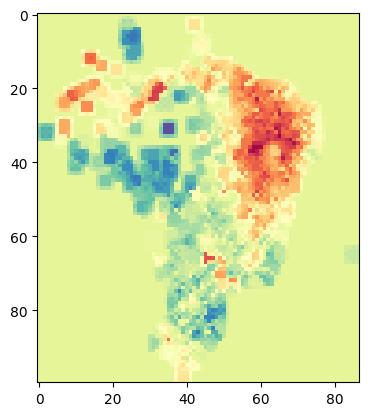

In [137]:
n = 50
q = 0.999
k = 0.001/9
kernel = [
    [k,  k,  k],
    [k,  q,  k],
    [k,  k,  k]
]

lula = map_lula_1t
bolsonaro = map_bolsonaro_1t
outros = map_outros_1t
for i in range(n):
    lula       = signal.convolve2d(lula,      kernel, mode="same")
    bolsonaro  = signal.convolve2d(bolsonaro, kernel, mode="same")
    outros     = signal.convolve2d(outros,    kernel, mode="same")
    delta      = lula - bolsonaro
    
log1p_lula      = np.apply_along_axis(np.log1p, 1, lula)
log1p_bolsonaro = np.apply_along_axis(np.log1p, 1, bolsonaro)
log1p_outros    = np.apply_along_axis(np.log1p, 1, outros)

min_lula       = np.min(log1p_lula)
min_bolsonaro  = np.min(log1p_bolsonaro)
min_outros     = np.min(log1p_outros)
max_lula       = np.max(log1p_lula)
max_bolsonaro  = np.max(log1p_bolsonaro)
max_outros     = np.max(log1p_outros)
min_data       = min([min_lula, min_bolsonaro, min_outros])
max_data       = max([max_lula, max_bolsonaro, max_outros])


lula_norm       = (255 * (log1p_lula.ravel()      / max_data)).reshape(lula.shape).astype(int)
bolsonaro_norm  = (255 * (log1p_bolsonaro.ravel() / max_data)).reshape(bolsonaro.shape).astype(int)
outros_norm     = (  0 * (log1p_outros.ravel()    / max_data)).reshape(outros.shape).astype(int)

#rgb_data = np.dstack([lula_norm, bolsonaro_norm, outros_norm ])
#plt.imshow(rgb_data)
#plt.show()

plt.imshow(bolsonaro_norm-lula_norm, cmap="Spectral")

plt.show()

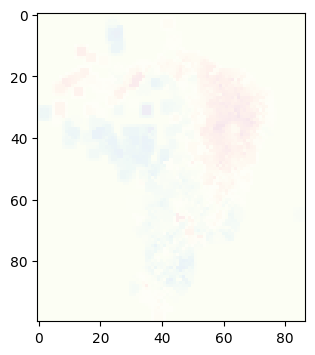

In [152]:

# setup Lambert Conformal basemap.
m = Basemap(width=12000000,height=9000000,projection='lcc',
            resolution='c',lat_1=45.,lat_2=55,lat_0=50,lon_0=-107.)
# draw coastlines.
m.drawcoastlines()
# draw a boundary around the map, fill the background.
# this background will end up being the ocean color, since
# the continents will be drawn on top.
m.drawmapboundary(fill_color='aqua')
# fill continents, set lake color same as ocean color.
m.fillcontinents(color='coral',lake_color='aqua')
plt.show()

Pandas(Index=1493, ano_eleicao=2022, nr_turno=1, ds_eleicao='Eleição Geral Federal 2022', sg_uf='AM', nr_zona=44, longitude=-122.4194155, latitude=37.7749295, lula=15618, bolsonaro=6135, outros=975)
Pandas(Index=2455, ano_eleicao=2022, nr_turno=2, ds_eleicao='Eleição Geral Federal 2022', sg_uf='AM', nr_zona=44, longitude=-122.4194155, latitude=37.7749295, lula=14514, bolsonaro=6711, outros=0)


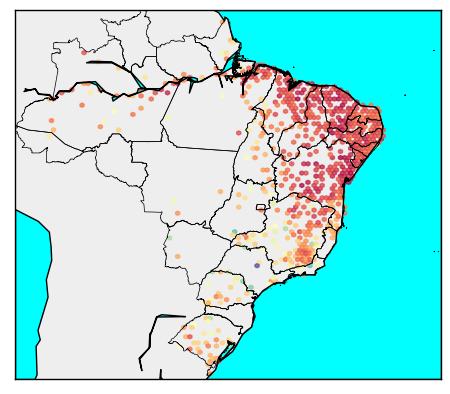

In [202]:
# setup Lambert Conformal basemap.
m = Basemap(
    #width=12000000,
    #height=9000000,
    #projection='lcc',
    #resolution='c',
    llcrnrlat=SOUTH_LAT, # latitude of lower left hand corner of the desired map domain (degrees).
    llcrnrlon=WEST_LNG, # longitude of lower left hand corner of the desired map domain (degrees).
    urcrnrlat=NORTH_LAT, # latitude of upper right hand corner of the desired map domain (degrees).
    urcrnrlon=EAST_LNG, # longitude of upper right hand corner of the desired map domain (degrees).
)
# draw coastlines.
m.drawcoastlines()
m.readshapefile(ESTADOS_SHP, "Estados", default_encoding='iso-8859-15')
#m.drawcountries()
#m.drawstates()
# draw a boundary around the map, fill the background.
# this background will end up being the ocean color, since
# the continents will be drawn on top.
m.drawmapboundary(fill_color='cyan')
# fill continents, set lake color same as ocean color.
m.fillcontinents(color='#eeeeee',lake_color='cyan')

xs        = []
ys        = []
lula      = []
bolsonaro = []
outros    = []

for row in votos_df.itertuples():
    if not (SOUTH_LAT <= row.latitude <= NORTH_LAT and WEST_LNG <= row.longitude < EAST_LNG):
        print(row)
        continue
    xs.append(row.longitude)
    ys.append(row.latitude)
    lula.append(row.lula)
    bolsonaro.append(row.bolsonaro)
    outros.append(row.bolsonaro)

m.hexbin(np.array(xs), np.array(ys), C=np.array(lula) - np.array(bolsonaro), cmap="Spectral_r", alpha=0.75, bins="log")

plt.show()

